In [ ]:
import os
os.chdir("/scratch/gilbreth/li3311/COVID_predict")

# COVID Prediction Project
### Zequn Li
-----

## 0. Project Architecture

#### Core equation:
##### Existing(t+1) = Existing(t) + NewConfirmed(t) - Death(t) - Cured(t)
#### Specifically:
##### NewConfirmed(t) = NewTested(t) * InfectionRate(t, state demographic distribution, state mobility, ?other information: population density, temperature, Existing, surrounding state existing, ...)
##### Death(t) = Existing(t+dt1) * DeathRate(state demographic)
##### Cured(t) = Existing(t+dt2) * RecoverRate(demographic)

## 1. Exploration Data Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### 1.1 State Demographic

In [2]:
# Mapping race, sex and age columns using consistent names (throughout the analysis)
dict_race = {1: "White, Non-Hispanic",
             2: "Black, Non-Hispanic",
             3: "American Indian/Alaska Native, Non-Hispanic",
             4: "Asian, Non-Hispanic",
             5: "Native Hawaiian/Other Pacific Islander, Non-Hispanic",
             6: "Multiple/Other, Non-Hispanic"}

def tag_race(row):
    if row.ORIGIN == 2:
        return "Hispanic/Latino"
    else:
        return dict_race[row.RACE]

def tag_sex(row):
    if row.SEX == 1:
        return "Male"
    else:
        return "Female"

def tag_age_group(row):
    return row.AGE // 10

In [3]:
stateDemo = pd.read_csv("data/sc-est2019-alldata6.csv")
stateDemo.head(5)

,SUMLEV,REGION,DIVISION,STATE,NAME,SEX,ORIGIN,RACE,AGE,CENSUS2010POP,...,POPESTIMATE2010,POPESTIMATE2011,POPESTIMATE2012,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017,POPESTIMATE2018,POPESTIMATE2019
0,40,3,6,1,Alabama,0,0,1,0,37991,...,37818,38678,37824,36812,37575,37698,37629,37526,36370,35594
1,40,3,6,1,Alabama,0,0,1,1,38150,...,38036,37719,38597,37854,36968,37882,37732,37904,37641,36679
2,40,3,6,1,Alabama,0,0,1,2,39738,...,39570,38202,37653,38528,37769,37123,38048,37975,38172,37904
3,40,3,6,1,Alabama,0,0,1,3,39827,...,39805,39690,38113,37716,38605,37896,37266,38170,38197,38510
4,40,3,6,1,Alabama,0,0,1,4,39353,...,39493,39872,39628,38122,37751,38625,37954,37322,38312,38476


In [4]:
# Filter for state population data of each (sex-race-age) combination
# df_sum_stateDemo: pd.DataFrame
stateDemo = stateDemo[["NAME", "SEX", "ORIGIN", "RACE", "AGE", "POPESTIMATE2019"]]
stateDemo = stateDemo[(stateDemo.SEX != 0)&
                      (stateDemo.ORIGIN != 0)]
stateDemo["RACE"] = stateDemo.apply(tag_race, axis=1)
stateDemo["SEX"] = stateDemo.apply(tag_sex, axis=1)
stateDemo["AGE_GROUP"] = stateDemo.apply(tag_age_group, axis=1)

df_sum_stateDemo = stateDemo[["NAME", "SEX", "RACE", "AGE_GROUP", "POPESTIMATE2019"]].groupby(["NAME", "SEX", "RACE", "AGE_GROUP"]).sum()

In [5]:
# Re-format df_sum_stateDemo into a 4D array to facilitate the computation
# of marginal distribution across multiple categories
name_list = stateDemo["NAME"].unique().tolist()
sex_list = stateDemo["SEX"].unique().tolist()
race_list = stateDemo["RACE"].unique().tolist()
age_list = stateDemo["AGE_GROUP"].unique().tolist()

data_ = np.zeros((len(name_list), len(sex_list), len(race_list), len(age_list))).astype(int)
for i, name in enumerate(name_list):
    for j, sex in enumerate(sex_list):
        for k, race in enumerate(race_list):
            for l, age in enumerate(age_list):
                data_[i,j,k,l] = df_sum_stateDemo.loc[(name, sex, race, age), :]

In [6]:
df_sum_stateDemo.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6426 entries, ('Alabama', 'Female', 'American Indian/Alaska Native, Non-Hispanic', 0) to ('Wyoming', 'Male', 'White, Non-Hispanic', 8)
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   POPESTIMATE2019  6426 non-null   int64
dtypes: int64(1)
memory usage: 399.3+ KB


### 1.1.1 State Demographic Visualization

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap as Basemap
from matplotlib.colors import rgb2hex, Normalize
from matplotlib.patches import Polygon
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cm as cm

def plot_map(data, title="", cmap=plt.cm.hot, vmin_=None, vmax_=None):
    ATOLL_CUTOFF = 0.005

    m = Basemap(llcrnrlon=-121,llcrnrlat=20,urcrnrlon=-62,urcrnrlat=51,
        projection='lcc',lat_1=32,lat_2=45,lon_0=-95)

    m.readshapefile('d:/state_shape/st99_d00', name='states', drawbounds=True)

    ax = plt.gca()

    colors={}
    statenames=[]
    vmin = np.min(data.values) if not vmin_ else vmin_
    vmax = np.max(data.values) if not vmax_ else vmax_

    for shapedict in m.states_info:
        statename = shapedict['NAME']
        if statename in data.index:
            num = data.loc[statename,:][0]
            colors[statename] = cmap((num-vmin)/(vmax-vmin))
            statenames.append(statename)

    for i, shapedict in enumerate(m.states_info):
        statename = shapedict['NAME']
        seg = m.states[int(shapedict['SHAPENUM'] - 1)]
        
        if statename in ['Alaska', 'Hawaii']:
            if statename == 'Hawaii' and float(shapedict['AREA']) > ATOLL_CUTOFF:
                seg = list(map(lambda s_: (s_[0] + 5200000, s_[1]-1400000), seg))
            elif statename == 'Alaska':
                seg = list(map(lambda s_: (0.35*s_[0] + 1100000, 0.35*s_[1]-1300000), seg))

        try:
            color = rgb2hex(colors[statename]) 
            poly = Polygon(seg,facecolor=color,edgecolor="k", linewidth=0.5)
            ax.add_patch(poly)
        except:
            pass
        
    fig = plt.gcf()
    im = plt.gci()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    norm = Normalize(vmin=vmin, vmax=vmax)
    sm = cm.ScalarMappable(cmap=cmap)
    cb = fig.colorbar(sm, ax=ax, cax=cax, orientation='vertical')
    ax_ = cb.ax.get_yaxis()
    ax_.set_ticks([0,1])
    ax_.set_ticklabels(["%.3f"%vmin, "%.3f"%vmax])
    ax.set_title(title)
    return fig

C:\Users\zequn\.conda\envs\ml\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  del sys.path[0]
C:\Users\zequn\.conda\envs\ml\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  from ipykernel import kernelapp as app


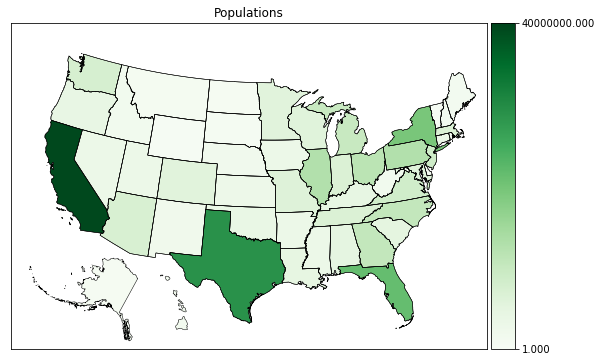

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(11, 6))
data = pd.DataFrame(data_.sum(axis=(1,2,3)), index=name_list)
ax = plot_map(data, title="Populations", cmap=plt.cm.Greens, vmin_=1, vmax_=4e7)
fig.savefig("d:/COVID_predict/plots/demo_pop.png", dpi=400)

C:\Users\zequn\.conda\envs\ml\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  del sys.path[0]
C:\Users\zequn\.conda\envs\ml\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  from ipykernel import kernelapp as app


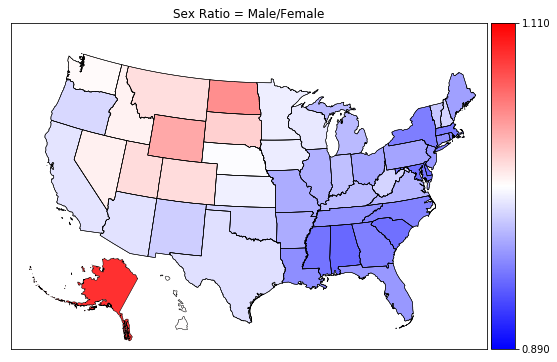

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(11, 6))
data = pd.DataFrame(data_.sum(axis=(2,3)), index=name_list, columns=sex_list)
data["sex_ratio"] = data["Male"] / data["Female"]
ax = plot_map(data[["sex_ratio"]], title="Sex Ratio = Male/Female", cmap=plt.cm.bwr, vmin_=0.89, vmax_=1.11)
fig.savefig("d:/COVID_predict/plots/demo_sex.png", dpi=400)

C:\Users\zequn\.conda\envs\ml\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  del sys.path[0]
C:\Users\zequn\.conda\envs\ml\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  from ipykernel import kernelapp as app


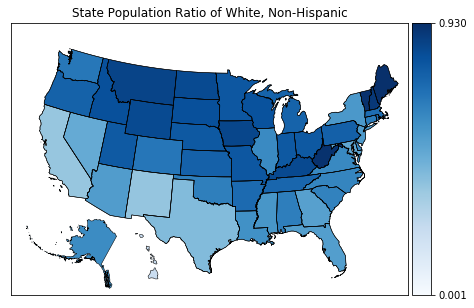

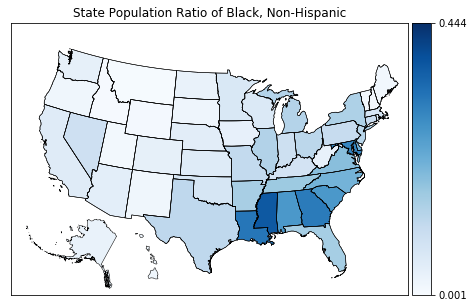

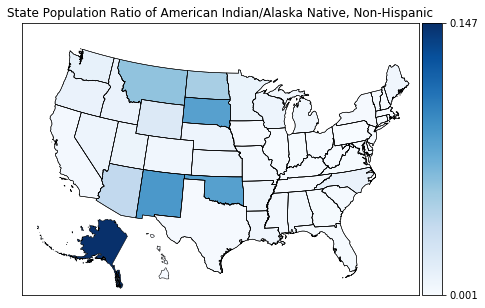

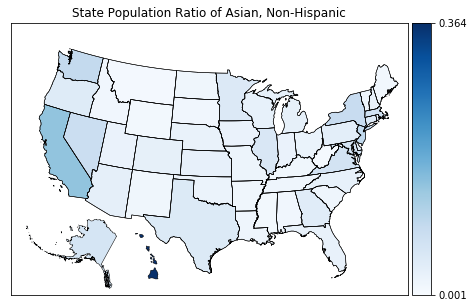

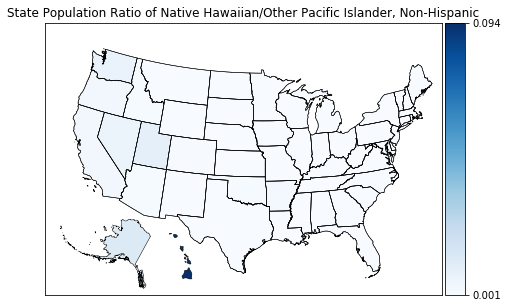

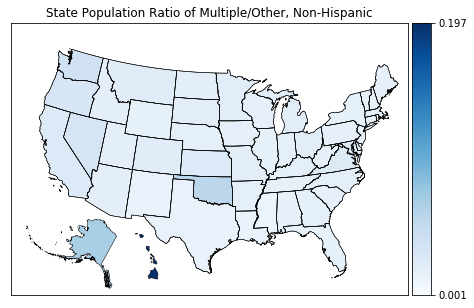

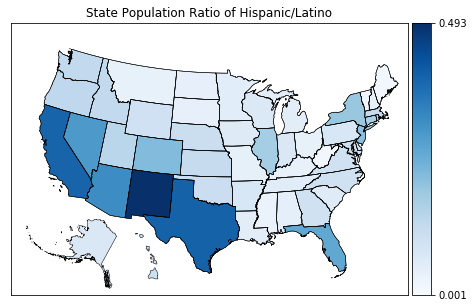

In [11]:
data_race = data_.sum(axis=(1,3)) / data_.sum(axis=(1,2,3))[:,None]
for i, race in enumerate(race_list):
    fig, ax = plt.subplots(1, 1, figsize=(9,5))
    data = pd.DataFrame(data_race[:, i], index=name_list)

    ax = plot_map(data, title="State Population Ratio of "+race, cmap=plt.cm.Blues, vmin_=1e-3, vmax_=max(data))
    fig.savefig("d:/COVID_predict/plots/demo_statepop_race_"+"".join(race.split("/"))+".png", dpi=400)

C:\Users\zequn\.conda\envs\ml\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  del sys.path[0]
C:\Users\zequn\.conda\envs\ml\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  from ipykernel import kernelapp as app


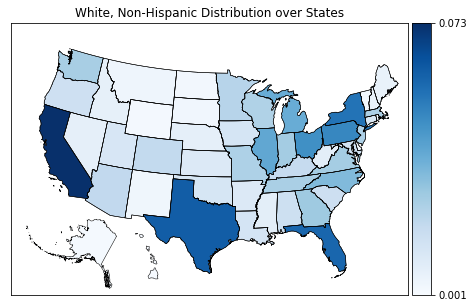

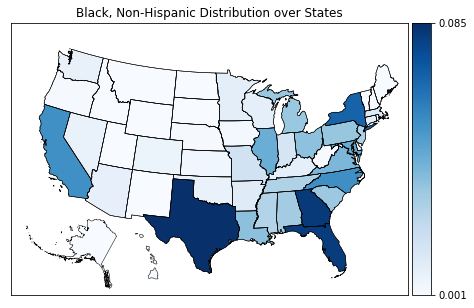

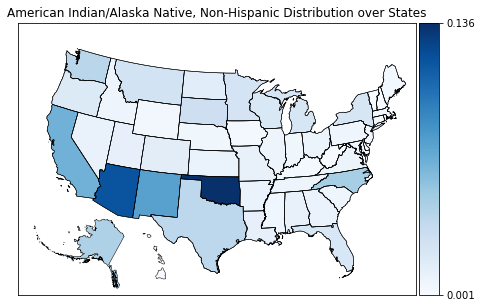

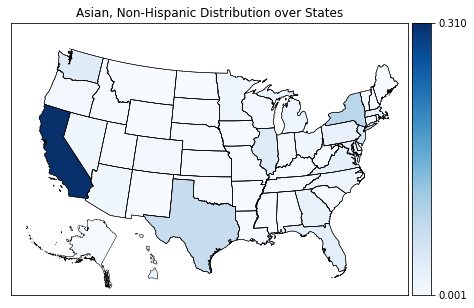

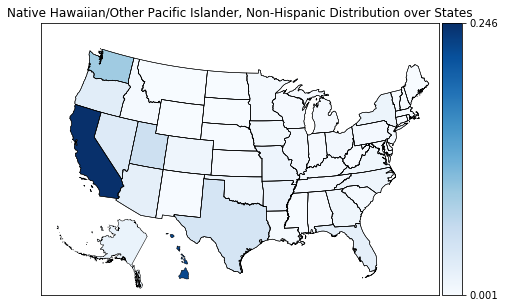

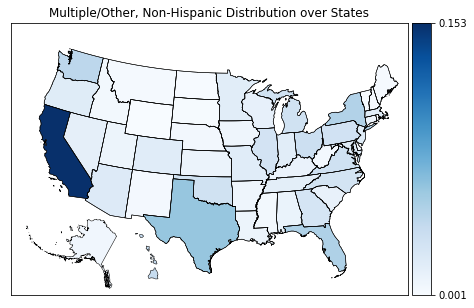

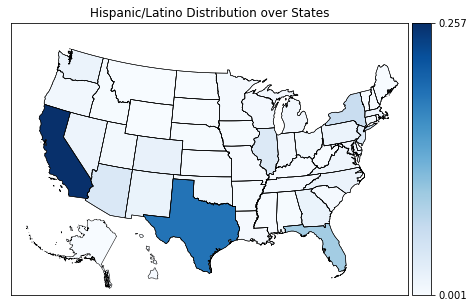

In [12]:
data_race = data_.sum(axis=(1,3)) / data_.sum(axis=(0,1,3))[None,:]
for i, race in enumerate(race_list):
    fig, ax = plt.subplots(1, 1, figsize=(9,5))
    data = pd.DataFrame(data_race[:, i], index=name_list)

    ax = plot_map(data, title=race+" Distribution over States", cmap=plt.cm.Blues, vmin_=1e-3, vmax_=max(data))
    fig.savefig("d:/COVID_predict/plots/demo_diststate_race_"+"".join(race.split("/"))+".png", dpi=400)

C:\Users\zequn\.conda\envs\ml\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  del sys.path[0]
C:\Users\zequn\.conda\envs\ml\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  from ipykernel import kernelapp as app


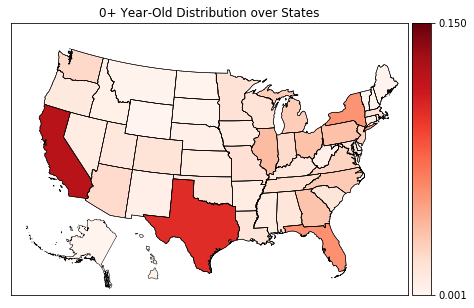

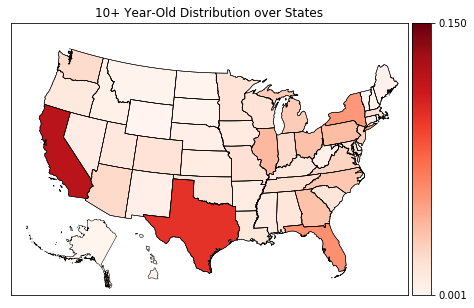

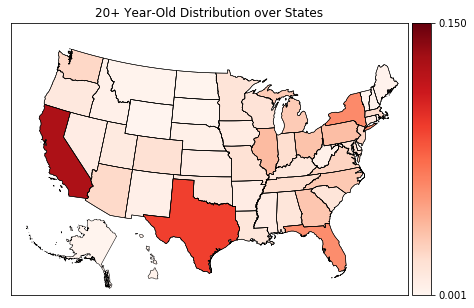

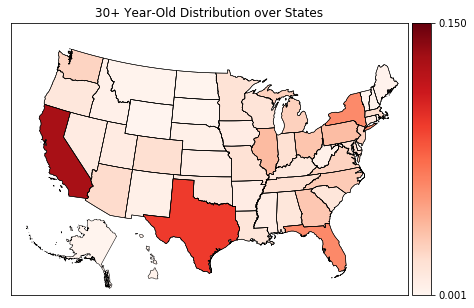

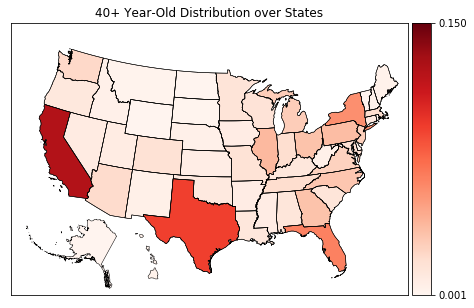

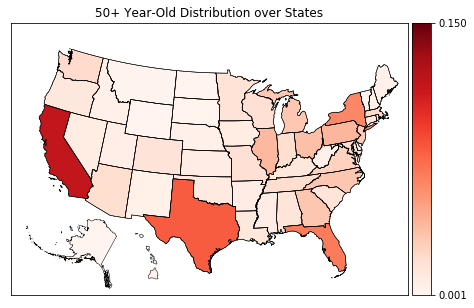

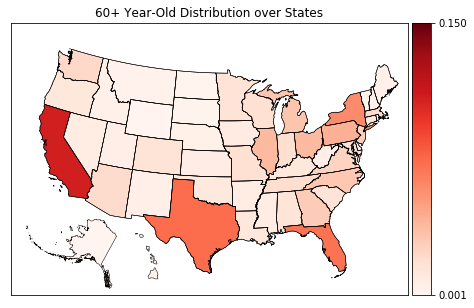

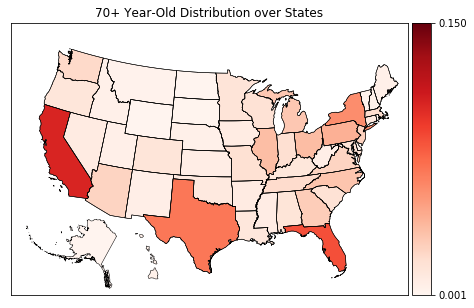

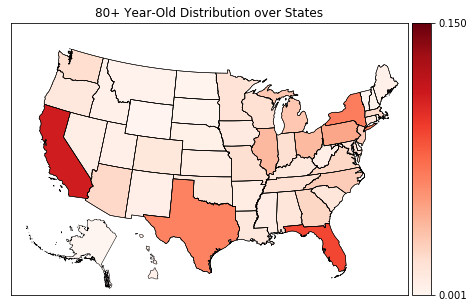

In [13]:
data_age = data_.sum(axis=(1,2)) / data_.sum(axis=(0,1,2))[None, :]

for i, age in enumerate(age_list):
    fig, ax = plt.subplots(1, 1, figsize=(9,5))
    data = pd.DataFrame(data_age[:,i], index=name_list)
    ax = plot_map(data, title=str(age)+ ("0" if age > 0 else "") + "+" + " Year-Old Distribution over States", cmap=plt.cm.Reds, vmin_=1e-3, vmax_=0.15)
    fig.savefig("d:/COVID_predict/plots/demo_diststate_age"+str(age)+".png", dpi=400)

C:\Users\zequn\.conda\envs\ml\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  del sys.path[0]
C:\Users\zequn\.conda\envs\ml\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  from ipykernel import kernelapp as app


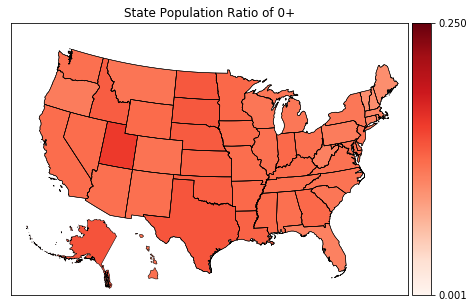

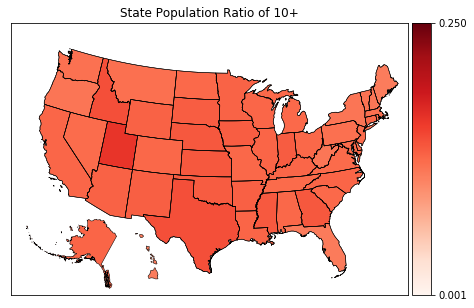

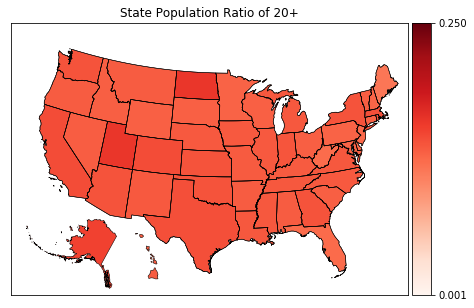

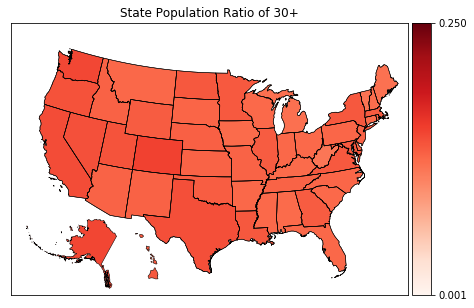

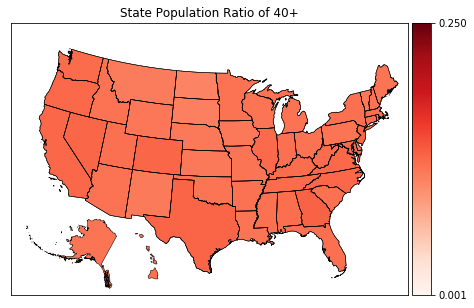

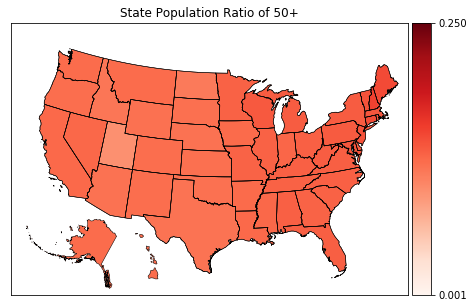

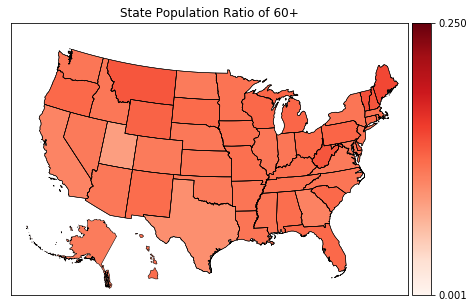

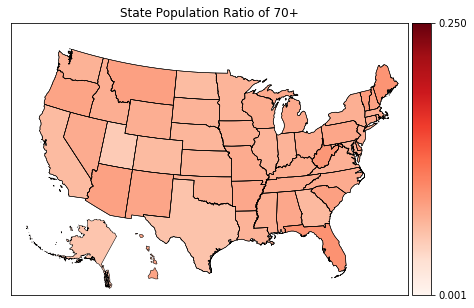

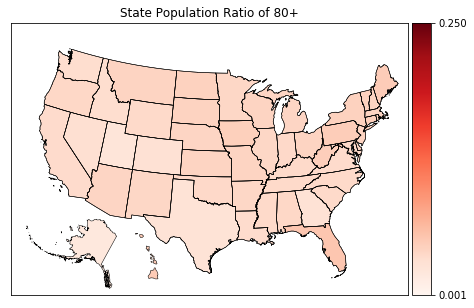

In [14]:
data_age = data_.sum(axis=(1,2)) / data_.sum(axis=(1,2,3))[:, None]

for i, age in enumerate(age_list):
    fig, ax = plt.subplots(1, 1, figsize=(9,5))
    data = pd.DataFrame(data_age[:,i], index=name_list)
    ax = plot_map(data, title="State Population Ratio of "+str(age)+ ("0" if age > 0 else "") + "+", cmap=plt.cm.Reds, vmin_=1e-3, vmax_=0.25)
    fig.savefig("d:/COVID_predict/plots/demo_statepop_age"+str(age)+".png", dpi=400)

###  1.2 COVID Public Surveillance Data

In [16]:
DeathRate = pd.read_csv("data/COVID-19_Case_Surveillance_Public_Use_Data.csv")
DeathRate.info()

C:\Users\zequn\.conda\envs\ml\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5760066 entries, 0 to 5760065
Data columns (total 11 columns):
 #   Column                         Dtype 
---  ------                         ----- 
 0   cdc_report_dt                  object
 1   pos_spec_dt                    object
 2   onset_dt                       object
 3   current_status                 object
 4   sex                            object
 5   age_group                      object
 6   Race and ethnicity (combined)  object
 7   hosp_yn                        object
 8   icu_yn                         object
 9   death_yn                       object
 10  medcond_yn                     object
dtypes: object(11)
memory usage: 483.4+ MB


In [17]:
DeathRate.head(5)

,cdc_report_dt,pos_spec_dt,onset_dt,current_status,sex,age_group,Race and ethnicity (combined),hosp_yn,icu_yn,death_yn,medcond_yn
0,2020/06/30,NaN,NaN,Probable Case,Other,0 - 9 Years,Unknown,Unknown,Unknown,No,Unknown
1,2020/06/30,NaN,NaN,Probable Case,Other,0 - 9 Years,Unknown,Unknown,Unknown,No,Unknown
2,2020/07/05,NaN,NaN,Laboratory-confirmed case,Other,0 - 9 Years,Unknown,Missing,Missing,Missing,Missing
3,2020/06/10,NaN,2020/03/27,Probable Case,Other,0 - 9 Years,Unknown,No,Unknown,No,Unknown
4,2020/07/13,NaN,2020/04/20,Probable Case,Other,0 - 9 Years,Unknown,No,Unknown,No,Unknown


In [18]:
print(sex_list)
print(age_list)
print(race_list)

['Male', 'Female']
[0, 1, 2, 3, 4, 5, 6, 7, 8]
['White, Non-Hispanic', 'Black, Non-Hispanic', 'American Indian/Alaska Native, Non-Hispanic', 'Asian, Non-Hispanic', 'Native Hawaiian/Other Pacific Islander, Non-Hispanic', 'Multiple/Other, Non-Hispanic', 'Hispanic/Latino']


In [19]:
# Filter the raw data by deleting records with missing data in sex, race and age columns
DeathRate["death"] = (DeathRate["death_yn"] == "Yes").astype(bool) # Change death indicator variable from Yes/No to 1/0
DeathRate = DeathRate[["sex", "age_group", "Race and ethnicity (combined)", "death"]]
DeathRate = DeathRate[(DeathRate["sex"].isin(["Male", "Female"]))&
                        (~DeathRate["Race and ethnicity (combined)"].isin(["Unknown", "NA"]))&
                        (~DeathRate["age_group"].isin(["Unknown", "NA"]))]
DeathRate["age_group"] = DeathRate["age_group"].apply(lambda row: int(row[0]))

In [20]:
# Summarize the number of confirmed and death rate data for each sex, age and race combination
DeathRate.reset_index(drop=True, inplace=True) # Notice: Filtered ~40% data, bias?
df_sum_dr = DeathRate.groupby(["sex", "age_group", "Race and ethnicity (combined)"]).agg(["mean", "count"])
df_sum_dr.reset_index(inplace=True)
df_sum_dr

sex age_group                      Race and ethnicity (combined)  \
                                                                           
0    Female         0        American Indian/Alaska Native, Non-Hispanic   
1    Female         0                                Asian, Non-Hispanic   
2    Female         0                                Black, Non-Hispanic   
3    Female         0                                    Hispanic/Latino   
4    Female         0                       Multiple/Other, Non-Hispanic   
..      ...       ...                                                ...   
121    Male         8                                Black, Non-Hispanic   
122    Male         8                                    Hispanic/Latino   
123    Male         8                       Multiple/Other, Non-Hispanic   
124    Male         8  Native Hawaiian/Other Pacific Islander, Non-Hi...   
125    Male         8                                White, Non-Hispanic   

        death         
         mean  count  
0    0.000000   1154  
1    0.000000   1544  
2    0.000594  10109  
3    0.000351  22781  
4    0.000337   2966  
..        ...    ...  
121  0.378761   9605  
122  0.391887   7839  
123  0.352417   2917  
124  0.430233     86  
125  0.363906  49969  

[126 rows x 5 columns]

In [21]:
# Defined a helper function to compute the marginal distribution of different categories
# using the 4D array defined earlier
data = data_.sum(axis=0)
def find_sum(row, data=data):
    return data[sex_list.index(row.sex), race_list.index(row['Race and ethnicity (combined)']), age_list.index(row.age_group)]

In [22]:
# Computing the state-wide confirmation rate given the demographic data
# cleaned previously
new_columns = ["".join(col) for col in df_sum_dr.columns]
df_sum_dr.columns = new_columns
df_sum_dr["total_pop"] = df_sum_dr.apply(lambda row: find_sum(row), axis=1)
df_sum_dr["confirmed_ratio"] = df_sum_dr["deathcount"] / df_sum_dr["total_pop"]

### 1.2.1 COVID data visualization over demographic

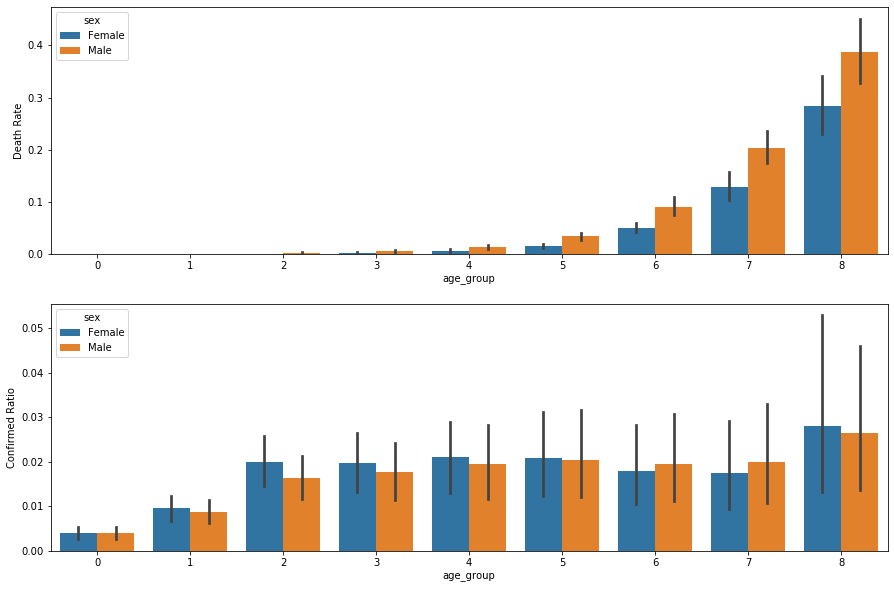

In [24]:
fig, axs = plt.subplots(2,1,figsize=(15,10))
sns.barplot(data=df_sum_dr, x="age_group", y="deathmean", hue="sex", ax=axs[0])
axs[0].set_ylabel('Death Rate')

sns.barplot(data=df_sum_dr, x="age_group", y="confirmed_ratio", hue="sex", ax=axs[1])
axs[1].set_ylabel('Confirmed Ratio')
fig.savefig("d:/COVID_predict/plots/covid_confirmed_death_rate_age_sex.png", dpi=400)

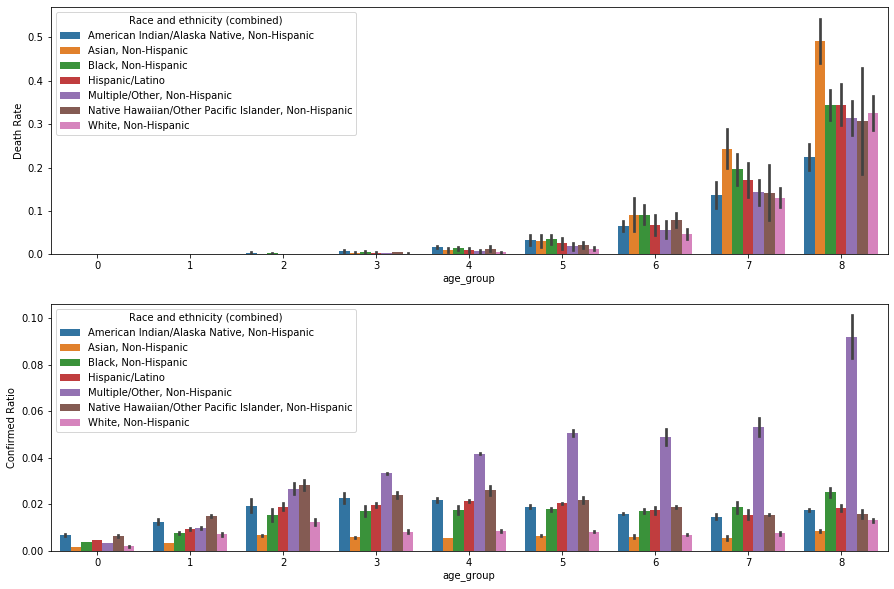

In [25]:
fig, axs = plt.subplots(2,1,figsize=(15,10))
sns.barplot(data=df_sum_dr, x="age_group", y="deathmean", hue="Race and ethnicity (combined)", ax=axs[0])
axs[0].set_ylabel("Death Rate")

sns.barplot(data=df_sum_dr, x="age_group", y="confirmed_ratio", hue="Race and ethnicity (combined)", ax=axs[1])
axs[1].set_ylabel('Confirmed Ratio')
fig.savefig("d:/COVID_predict/plots/covid_confirmed_death_rate_age_race.png", dpi=400)

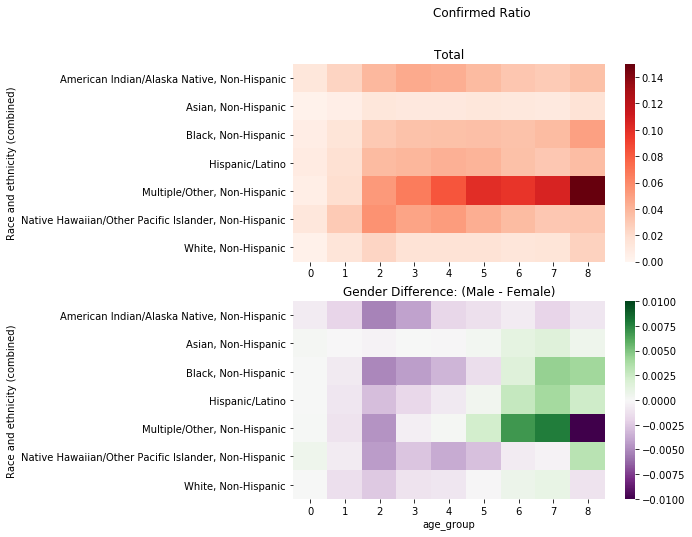

In [28]:
fig, axs = plt.subplots(2,1,figsize=(7,8))

fig.suptitle("Confirmed Ratio")
axs[0].set_title("Total")

axs[1].set_title("Gender Difference: (Male - Female)")

df_diff = pd.pivot_table(df_sum_dr[df_sum_dr.sex=="Male"], values='confirmed_ratio', columns=['age_group'], index=['Race and ethnicity (combined)'], aggfunc=np.sum) - pd.pivot_table(df_sum_dr[df_sum_dr.sex=="Female"], values='confirmed_ratio', columns=['age_group'], index=['Race and ethnicity (combined)'], aggfunc=np.sum)
sns.heatmap(pd.pivot_table(df_sum_dr, values='confirmed_ratio', columns=['age_group'], index=['Race and ethnicity (combined)'], aggfunc=np.sum), vmin=0, vmax=1.5e-1, ax=axs[0], cmap="Reds")
axs[0].set_xlabel("")
sns.heatmap(df_diff, vmin=-1e-2, vmax=1e-2, ax=axs[1], cmap="PRGn")

fig.savefig("d:/COVID_predict/plots/covid_confirmed_rate_heatmap.png", dpi=400)

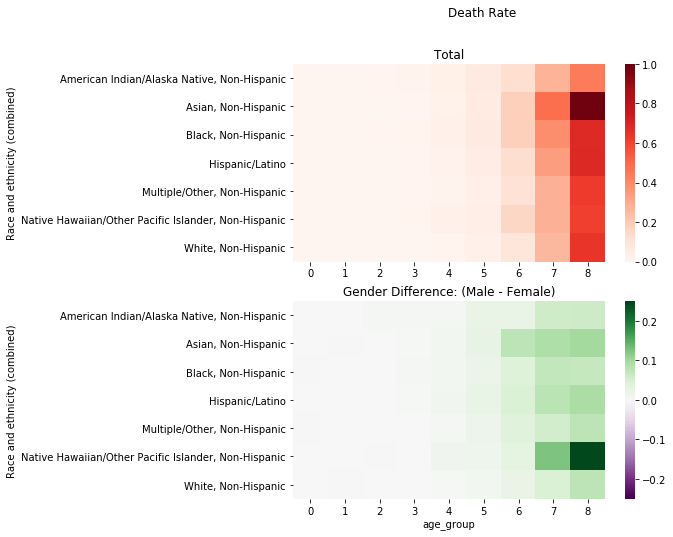

In [29]:
fig, axs = plt.subplots(2,1,figsize=(7,8))
fig.suptitle("Death Rate")
axs[0].set_title("Total")
axs[1].set_title("Gender Difference: (Male - Female)")

df_diff = pd.pivot_table(df_sum_dr[df_sum_dr.sex=="Male"], values='deathmean', columns=['age_group'], index=['Race and ethnicity (combined)'], aggfunc=np.sum) - pd.pivot_table(df_sum_dr[df_sum_dr.sex=="Female"], values='deathmean', columns=['age_group'], index=['Race and ethnicity (combined)'], aggfunc=np.sum)
sns.heatmap(pd.pivot_table(df_sum_dr, values='deathmean', columns=['age_group'], index=['Race and ethnicity (combined)'], aggfunc=np.sum), vmin=0, vmax=1, ax=axs[0], cmap="Reds")
axs[0].set_xlabel("")
sns.heatmap(df_diff, vmin=-0.25, vmax=0.25, ax=axs[1], cmap="PRGn")
fig.savefig("d:/COVID_predict/plots/covid_death_rate_heatmap.png", dpi=400)

In [30]:
# Tag sex, race and age information for the new dataframe
df_sum_dr["s_"] = df_sum_dr["sex"].apply(lambda x: {r:i for i, r in enumerate(sex_list)}[x])
df_sum_dr["r_"] = df_sum_dr["Race and ethnicity (combined)"].apply(lambda x: {r:i for i, r in enumerate(race_list)}[x])
df_sum_dr["a_"] = df_sum_dr["age_group"].apply(lambda x: {r:i for i, r in enumerate(age_list)}[x])

In [31]:
# Compute the corrected death rate given demographic
demo_prop = (data_ / data_.sum(axis=(1,2,3))[:,None,None,None])
demo_dr = df_sum_dr.sort_values(by=["s_", "r_", "a_"])["deathmean"].values.reshape([2,7,9])
state_random_dr = pd.DataFrame((demo_prop * demo_dr[None, :]).sum(axis=(1,2,3))*100, index=name_list, columns=["deathrate_c"])

C:\Users\zequn\.conda\envs\ml\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  del sys.path[0]
C:\Users\zequn\.conda\envs\ml\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  from ipykernel import kernelapp as app


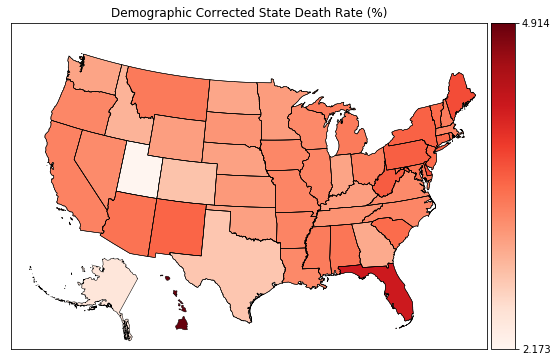

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(11, 6))
data = pd.DataFrame(state_random_dr, index=name_list, columns=["deathrate_c"])
ax = plot_map(state_random_dr, title="Demographic Corrected State Death Rate (%)",  cmap=plt.cm.Reds)
fig.savefig("d:/COVID_predict/plots/covid_corrected_death_rate.png", dpi=400)

In [33]:
# Helper dictionary of state name vs abbreviation
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

In [34]:
state_random_dr["AB"] = list(map(lambda x: us_state_abbrev[x], state_random_dr.index.values.tolist()))

In [35]:
# Include the latest observed cumulative death rate as the true death rate
# Compared it with the corrected death rate as above

import os
import datetime

path = "data/csse_covid_19_daily_reports_us/"
files = sorted(os.listdir(path))[:-1]
cols = ["Province_State", "Last_Update", "People_Tested", "Confirmed", "Deaths", "Recovered", "Active"]
df_all = pd.DataFrame(columns=cols)
for f in files:
    df_temp = pd.read_csv(path+f)
    df_all = df_all.append(df_temp[cols]).reset_index(drop=True)
df_all = df_all[df_all.Province_State.isin(state_random_dr.index)].reset_index(drop=True)
df_all["Last_Update"] = pd.to_datetime(df_all["Last_Update"]).dt.date
pop_sum = data_.sum(axis=(1,2,3))
df_all["Total_pop"] = df_all["Province_State"].apply(lambda x: pop_sum[name_list.index(x)])
df_obs = df_all.iloc[-51:, :].set_index("Province_State")
df_obs["deathrate_obs"] = df_obs["Deaths"] / df_obs["Confirmed"] * 100
state_random_dr["deathrate_obs"] = df_obs["Deaths"] / df_obs["Confirmed"] * 100

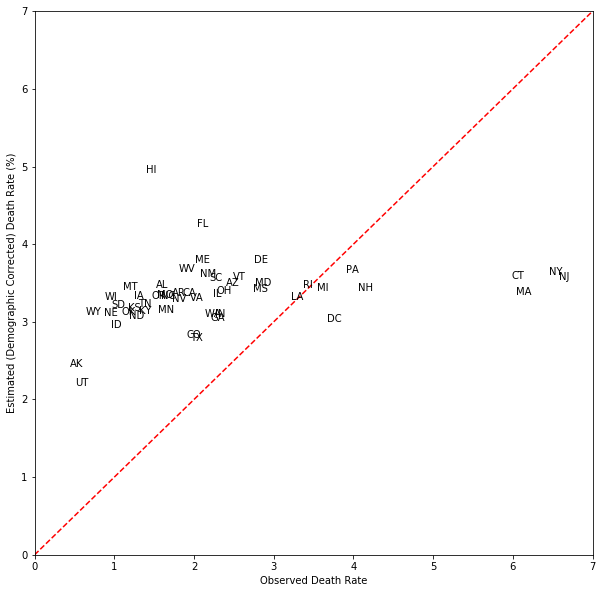

In [36]:
vmax = 7
fig, ax = plt.subplots(1,1,figsize=(10,10))
for _, row in state_random_dr.iterrows():
    ax.text(row["deathrate_obs"], row["deathrate_c"], row["AB"])


ax.plot([0,vmax], [0,vmax], "r--")
ax.set_xlim([0,vmax])
ax.set_ylim([0,vmax])
ax.set_xlabel("Observed Death Rate")
ax.set_ylabel("Estimated (Demographic Corrected) Death Rate (%)")
fig.savefig("d:/COVID_predict/plots/covid_true_corrected_death_rate_scatterplot.png", dpi=400)

In [37]:
# Compute the latest cumulative death rate and recover rate as the true rate for each state
df_rd = df_all[["Province_State", "Confirmed", "Deaths", "Recovered"]].groupby("Province_State").apply(lambda col: col.tail(1))

df_rd["final_DeathRate"] = df_rd["Deaths"] / df_rd["Confirmed"]
df_rd["final_RecoverRate"] = df_rd["Recovered"] / df_rd["Confirmed"]
df_rd.reset_index(drop=True, inplace=True)
df_rd["final_RecoverRate"].fillna(0., inplace=True)
dict_state_params = {}
for _, s in df_rd.iterrows():
    dict_state_params[s.Province_State] = {}
    dict_state_params[s.Province_State]["death_rate"] = s.final_DeathRate
    dict_state_params[s.Province_State]["recover_rate"] = s.final_RecoverRate

In [38]:
df_all.head(10)

,Province_State,Last_Update,People_Tested,Confirmed,Deaths,Recovered,Active,Total_pop
0,Alabama,2020-04-12,21583.0,3563,93,NaN,3470,4903185
1,Alaska,2020-04-12,8038.0,272,8,66.0,264,731545
2,Arizona,2020-04-12,42109.0,3542,115,NaN,3427,7278717
3,Arkansas,2020-04-12,19722.0,1280,27,367.0,1253,3017804
4,California,2020-04-12,190328.0,22795,640,NaN,22155,39512223
5,Colorado,2020-04-12,34873.0,7307,289,NaN,7018,5758736
6,Connecticut,2020-04-12,41220.0,12035,554,NaN,11481,3565287
7,Delaware,2020-04-12,11103.0,1625,35,191.0,1590,973764
8,District of Columbia,2020-04-12,10640.0,1875,50,493.0,1825,705749
9,Florida,2020-04-12,182753.0,19895,461,NaN,19434,21477737


In [39]:
# Compute the daily increase cases for different catefories and states
df_all["People_Tested_Daily"] = df_all.groupby("Province_State")["People_Tested"].diff(periods=1)
df_all["Confirmed_Daily"] = df_all.groupby("Province_State")["Confirmed"].diff(periods=1)
df_all["Deaths_Daily"] = df_all.groupby("Province_State")["Deaths"].diff(periods=1)
df_all["Recovered_Daily"] = df_all.groupby("Province_State")["Recovered"].diff(periods=1)

# The daily record data is very noisy and ratio of two noisy variable can exaggerate the randomness
# So I applied a rolling average of 7 days to smooth out the noise
df_all["People_Tested_Daily_r7"] = df_all.groupby("Province_State")["People_Tested_Daily"].apply(lambda col: col.rolling(7).mean())
df_all["Confirmed_Daily_r7"] = df_all.groupby("Province_State")["Confirmed_Daily"].apply(lambda col: col.rolling(7).mean())

df_all["Active_Ratio"] = df_all["Active"] / df_all["Total_pop"]
df_all["Active_Ratio_r7"] = df_all.groupby("Province_State")["Active_Ratio"].apply(lambda col: col.rolling(7).mean())

In [40]:
# Illustrate that because there might be a delay in knowing the result after taking the test,
# and this delay is not deterministically captured anywhere, it might be that more death or 
# recovereries are observed from the previous days and these numbers are greater than the 
# test cases of current day. This block is to show such cases, and possible some other abrupt
# negative changes
df_all.loc[
    (df_all.People_Tested_Daily < 0)|
    (df_all.Confirmed_Daily < 0)|
    (df_all.Deaths_Daily < 0)|
    (df_all.Recovered_Daily < 0), :]

,Province_State,Last_Update,People_Tested,Confirmed,Deaths,Recovered,Active,Total_pop,People_Tested_Daily,Confirmed_Daily,Deaths_Daily,Recovered_Daily,People_Tested_Daily_r7,Confirmed_Daily_r7,Active_Ratio,Active_Ratio_r7
52,Alaska,2020-04-13,7830.0,277,8,85.0,269,731545,-208.0,5,0,19.0,NaN,NaN,0.000367715,NaN
95,Utah,2020-04-13,45787.0,2363,13,218.0,2350,3205958,1553.0,60,-5,NaN,NaN,NaN,0.00073301,NaN
119,Kentucky,2020-04-14,26683.0,2048,106,629.0,1942,4467673,817.0,30,-7,22.0,NaN,NaN,0.000434678,NaN
131,New Hampshire,2020-04-14,11610.0,922,25,249.0,897,1359711,403.0,-63,2,10.0,NaN,NaN,0.000659699,NaN
203,Wyoming,2020-04-15,6329.0,287,1,129.0,286,578759,365.0,5,0,-11.0,NaN,NaN,0.000494161,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10289,Pennsylvania,2020-10-31,2503500.0,210586,8774,156192.0,45620,12801989,17796.0,2499,31,-22.0,16007.571429,2133.000000,0.00356351,0.003255
10505,Wyoming,2020-11-04,135336.0,14621,93,9312.0,5216,578759,1318.0,454,-4,349.0,1406.285714,402.142857,0.00901239,0.008044
10609,Alaska,2020-11-07,781301.0,18699,84,7122.0,11493,731545,-525.0,525,0,-3.0,27854.000000,398.714286,0.0157106,0.014044
10635,Nebraska,2020-11-07,1000225.0,80693,701,45658.0,34334,1934408,12727.0,2681,27,-114.0,11365.857143,1578.285714,0.0177491,0.015064


In [41]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

In [43]:
# helper function
def poly_smooth(s):
    t2 = (np.array(range(len(s)))**2).reshape(-1, 1)
    lr = LinearRegression(fit_intercept=False)
    lr.fit(t2, np.array(s.values))
    return lr.predict(t2), lr.coef_[0]

In [44]:
temp = df_all.groupby("Province_State")["People_Tested"].apply(lambda s: poly_smooth(s)[0])
for name, s in df_all.groupby("Province_State")["People_Tested"]:
     dict_state_params[name]["People_Tested_PolyCoef"] = poly_smooth(s)[1]

In [47]:
for i, s in enumerate(temp):
    fig, axs = plt.subplots(1, 1, figsize=(10, 4), tight_layout=True)
    pred_ = s
    true_ = df_all.loc[df_all.Province_State == name_list[i], "People_Tested"].values
    axs.plot(pred_, label="Predicted")
    axs.plot(true_, label="Observed")
    axs.text(0, 0.5*max(true_), "R^2: " + str(pearsonr(pred_, true_)[0])[:5])
    axs.set_title(name_list[i])
    axs.legend()
    axs.set_xlabel("Days")
    axs.set_ylabel("Number of Tested Cases")
    fig.savefig("d:/COVID_predict/plots/covid_fitted_test_cases_"+name_list[i]+".png", dpi=400)
    plt.close(fig)

In [49]:
%%time
for i, (name, df) in enumerate(df_all.groupby("Province_State")):
    fig, axs = plt.subplots(1, 5, figsize=(30,4))
    axs[0].plot(df["Last_Update"], df["People_Tested"] / df["Total_pop"], c="blue", label="Test Ratio = Tested / Total_Population")
    axs[0].plot(df["Last_Update"], df["Confirmed"] / df["People_Tested"], c="black", label="Positive Ratio = Confirmed / Tested")
    axs[0].plot(df["Last_Update"], df["Deaths"] / df["Confirmed"], c="red", label="Death Ratio = Dead / Tested")
    axs[0].plot(df["Last_Update"], df["Recovered"] / df["Confirmed"], c="green", label="Recover Ratio = Recovered / Tested")
    axs[0].legend(loc="upper left")
    axs[0].set_title(name)
    axs[0].set_ylim([0,1])
    axs[0].set_xlabel("Date")
    axs[0].set_ylabel("Ratio")
    
    axs[1].scatter(df["Last_Update"], df["People_Tested_Daily"], c="blue", s=.4, alpha=.6 , label="Observed Daily Tested Population")
    axs[1].plot(df["Last_Update"], df["People_Tested_Daily_r7"], c="blue", label="Smoothed Daily Tested Population")
    axs[1].legend(loc="upper left")
    axs[1].set_title(name)
    axs[1].set_xlabel("Date")
    axs[1].set_ylabel("Number of Cases")
    
    axs[2].scatter(df["Last_Update"], df["Confirmed_Daily"], c="black", s=.4, alpha=.6 ,label="Observed Daily Confirmed Population")
    axs[2].plot(df["Last_Update"], df["Confirmed_Daily_r7"], c="black", label="Smoothed Daily Tested Population")
    axs[2].legend(loc="upper left")
    axs[2].set_title(name)
    axs[2].set_xlabel("Date")
    axs[2].set_ylabel("Number of Cases")
    
    axs[3].plot(df["Last_Update"], df["Deaths_Daily"], c="red", label="Daily Deaths Population")
    axs[3].legend(loc="upper left")
    axs[3].set_title(name)
    axs[3].set_xlabel("Date")
    axs[3].set_ylabel("Number of Cases")
    
    axs[4].plot(df["Last_Update"], df["Recovered_Daily"], c="green", label="Daily Recovered Population")
    axs[4].legend(loc="upper left")
    axs[4].set_title(name)
    axs[4].set_xlabel("Date")
    axs[4].set_ylabel("Number of Cases")
    
    fig.savefig("d:/COVID_predict/plots/COVID_timeseries_state_"+name+".png", dpi=400)
    plt.close(fig)

Wall time: 1min 10s


In [50]:
# Apply a rolling average of 7 days and cut-off the unclean data, which is until 2020/04/23
data_covid = df_all[["Province_State", "Last_Update", "Active_Ratio_r7"]].copy()
data_covid["Smoothed_Confirmed_Ratio_r7"] = df_all["Confirmed_Daily_r7"] / df_all["People_Tested_Daily_r7"]
data_covid["Date"] = pd.to_datetime(data_covid["Last_Update"])
data_covid = data_covid.drop("Last_Update", axis=1)
data_covid = data_covid.loc[(data_covid.Date > datetime.datetime(2020, 4, 23)), :]
data_covid = data_covid.dropna().reset_index(drop=True)

In [51]:
data_covid.head(5)

,Province_State,Active_Ratio_r7,Smoothed_Confirmed_Ratio_r7,Date
0,Alabama,0.001014,0.091508,2020-04-24
1,Alaska,0.000430,0.010800,2020-04-24
2,Arizona,0.000674,0.135853,2020-04-24
3,Arkansas,0.000652,0.109815,2020-04-24
4,California,0.000825,0.050421,2020-04-24


In [52]:
data_covid.tail(5)

,Province_State,Active_Ratio_r7,Smoothed_Confirmed_Ratio_r7,Date
10093,Virginia,0.018817,0.066862,2020-11-07
10094,Washington,0.014195,0.056498,2020-11-07
10095,West Virginia,0.003136,0.053587,2020-11-07
10096,Wisconsin,0.008773,0.137646,2020-11-07
10097,Wyoming,0.009200,0.331371,2020-11-07


In [53]:
len(data_covid)/51 # 198 days of clean COVID data

198.0

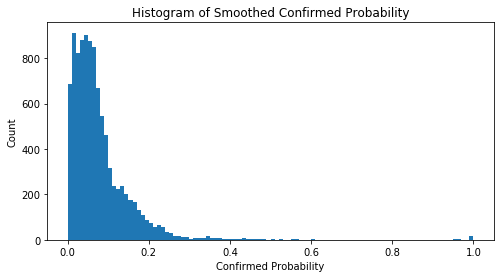

In [55]:
fig, ax = plt.subplots(1,1,figsize=(8,4))
hist_ = plt.hist(data_covid["Smoothed_Confirmed_Ratio_r7"], bins=100, range=(0,1))
ax.set_xlabel("Confirmed Probability")
ax.set_ylabel("Count")
ax.set_title("Histogram of Smoothed Confirmed Probability")

fig.savefig("d:/COVID_predict/plots/covid_smoothed_confirmed_probability.png", dpi=400)

### 1.3 Mobility data

In [56]:
mobility = pd.read_csv("data/Trips_by_Distance.csv")
mobility.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2162338 entries, 0 to 2162337
Data columns (total 19 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   Level                           object 
 1   Date                            object 
 2   State FIPS                      float64
 3   State Postal Code               object 
 4   County FIPS                     float64
 5   County Name                     object 
 6   Population Staying at Home      object 
 7   Population Not Staying at Home  object 
 8   Number of Trips                 object 
 9   Number of Trips <1              object 
 10  Number of Trips 1-3             object 
 11  Number of Trips 3-5             object 
 12  Number of Trips 5-10            object 
 13  Number of Trips 10-25           object 
 14  Number of Trips 25-50           object 
 15  Number of Trips 50-100          object 
 16  Number of Trips 100-250         object 
 17  Number of Trips 250-500    

In [57]:
mobility["Date"] = pd.to_datetime(mobility["Date"])
mobility.head(5)

,Level,Date,State FIPS,State Postal Code,County FIPS,County Name,Population Staying at Home,Population Not Staying at Home,Number of Trips,Number of Trips <1,Number of Trips 1-3,Number of Trips 3-5,Number of Trips 5-10,Number of Trips 10-25,Number of Trips 25-50,Number of Trips 50-100,Number of Trips 100-250,Number of Trips 250-500,Number of Trips >=500
0,County,2019-01-01,29.0,MO,29171.0,Putnam County,"1,155","3,587","12,429","2,807","3,642","1,272","1,240","1,953","1,058",283,101,54,19
1,County,2019-01-01,2.0,AK,2164.0,Lake and Peninsula Borough,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,County,2019-01-01,1.0,AL,1001.0,Autauga County,"9,624","45,807","132,004","27,097","35,263","18,315","18,633","22,963","5,149","2,575","1,592",322,95
3,County,2019-01-01,1.0,AL,1003.0,Baldwin County,"44,415","172,941","534,520","120,752","142,931","68,235","87,430","78,045","24,495","7,079","3,188","1,693",672
4,County,2019-01-01,1.0,AL,1005.0,Barbour County,"4,782","20,023","67,658","15,524","16,677","10,550","11,674","6,416","3,686","2,450",589,66,26


In [58]:
# Data type clean-up
mobility = mobility.loc[(mobility["Date"] > datetime.datetime(2020, 3, 25))&(mobility["State Postal Code"].notnull()),["Date", "State Postal Code"]+list(mobility.columns)[6:]].sort_values(by="Date").reset_index(drop=True)

def str2int(s):
    if s == "NaN":
        return float(np.nan)
    elif type(s) == str:
        return int(s.replace(",", ""))
    else:
        return s
cols = list(mobility.columns[2:])
for col in cols:
    print(col)
    mobility[col] = mobility[col].apply(str2int)

Population Staying at Home
Population Not Staying at Home
Number of Trips
Number of Trips <1
Number of Trips 1-3
Number of Trips 3-5
Number of Trips 5-10
Number of Trips 10-25
Number of Trips 25-50
Number of Trips 50-100
Number of Trips 100-250
Number of Trips 250-500
Number of Trips >=500


In [121]:
# Sum county-level record to state-lvel record
mobility_state = mobility.groupby(["Date", "State Postal Code"]).sum().reset_index()

In [122]:
ab_to_state = {value: key for (key, value) in us_state_abbrev.items()}
mobility_state["Province_State"] = mobility_state["State Postal Code"].apply(lambda x: ab_to_state[x])
mobility_state = mobility_state.drop("State Postal Code", axis=1)

# Add Stay-at-Home ratio as the measurement of people's protective awareness
mobility_state["Stay at Home Ratio"] = mobility_state["Population Staying at Home"] / (mobility_state["Population Staying at Home"] + mobility_state["Population Not Staying at Home"])

# A rolling average of 30 days is applied to all mobility data
# The assumption is that this time-window is a good measurement 
# of COVID infection probability
cols += ["Stay at Home Ratio"]
r30_cols = [col+"_r30" for col in cols]
for col in r30_cols:
    mobility_state[col] = mobility_state.groupby("Province_State")[col[:-4]].apply(lambda col: col.rolling(30).mean())
mobility_state = mobility_state.dropna().reset_index(drop=True)

In [123]:
# Since the population is different in each state, I added the per-person
# version of each mobility variable into the mobility dataset as well.
r30_pp_cols = [col + "_pp" for col in r30_cols[:-1]]
for col in r30_pp_cols:
    mobility_state[col] = mobility_state[col[:-7]] / mobility_state["Population Not Staying at Home"]
mobility_state = mobility_state.drop(cols, axis=1)

In [124]:
for i, (name, df) in enumerate(mobility_state.groupby("Province_State")):
    fig, axs = plt.subplots(1, 2, figsize=(15,4))
    axs[0].plot(df["Date"], df["Stay at Home Ratio_r30"], c="blue", label="30-Day Rolling Average of Stay at Home Ratio")
    axs[0].set_title(name)
    axs[0].set_xlabel("Date")
    axs[0].set_ylabel("Ratio")
    axs[0].set_ylim([0.1, 0.4])
    axs[0].legend()
    
    axs[1].plot(df["Date"], df["Number of Trips_r30_pp"], c="red", label="30-Day Rolling Average of Number of Trips Per Person")
    axs[1].set_title(name)
    axs[1].set_xlabel("Date")
    axs[1].set_ylabel("Trips per Person")
    axs[1].set_ylim([2, 7])
    axs[1].legend()
    
    fig.savefig("d:/COVID_predict/plots/mobility_"+name+".png", dpi=400)
    plt.close(fig)

In [125]:
mobility_state.head(5)

,Date,Province_State,Population Staying at Home_r30,Population Not Staying at Home_r30,Number of Trips_r30,Number of Trips <1_r30,Number of Trips 1-3_r30,Number of Trips 3-5_r30,Number of Trips 5-10_r30,Number of Trips 10-25_r30,...,Number of Trips 1-3_r30_pp,Number of Trips 3-5_r30_pp,Number of Trips 5-10_r30_pp,Number of Trips 10-25_r30_pp,Number of Trips 25-50_r30_pp,Number of Trips 50-100_r30_pp,Number of Trips 100-250_r30_pp,Number of Trips 250-500_r30_pp,Number of Trips >=500_r30_pp,Stay at Home Ratio_r30_pp
0,2020-04-24,Alaska,4.567547e+05,1.015585e+06,3.864920e+06,1.192758e+06,1.099668e+06,4.674816e+05,5.163965e+05,3.759541e+05,...,1.165759,0.523325,0.586787,0.376589,0.146356,0.039578,0.014524,0.002407,0.004732,3.023526e-07
1,2020-04-24,Alabama,2.204763e+06,7.570979e+06,2.669128e+07,6.401385e+06,6.862019e+06,3.486812e+06,4.142310e+06,3.816717e+06,...,0.965093,0.510809,0.616237,0.593673,0.202445,0.070106,0.025319,0.004783,0.000886,2.507420e-08
2,2020-04-24,Arkansas,1.349874e+06,4.677776e+06,1.601453e+07,3.765822e+06,4.232293e+06,2.018116e+06,2.467307e+06,2.264736e+06,...,0.985861,0.457298,0.565714,0.546207,0.192464,0.075500,0.030395,0.005244,0.000959,4.294017e-08
3,2020-04-24,Arizona,4.272286e+06,1.007101e+07,3.504036e+07,1.106100e+07,8.152537e+06,3.721135e+06,4.623004e+06,4.934665e+06,...,0.854656,0.410381,0.508529,0.543889,0.176820,0.059034,0.030660,0.005526,0.002266,2.672585e-08
4,2020-04-24,California,2.398063e+07,5.513346e+07,1.704809e+08,4.789348e+07,4.501210e+07,1.841680e+07,2.224384e+07,2.281114e+07,...,0.855172,0.373565,0.462879,0.479265,0.185262,0.065444,0.022961,0.005219,0.001650,4.956095e-09


In [126]:
mobility_state.tail(5)

,Date,Province_State,Population Staying at Home_r30,Population Not Staying at Home_r30,Number of Trips_r30,Number of Trips <1_r30,Number of Trips 1-3_r30,Number of Trips 3-5_r30,Number of Trips 5-10_r30,Number of Trips 10-25_r30,...,Number of Trips 1-3_r30_pp,Number of Trips 3-5_r30_pp,Number of Trips 5-10_r30_pp,Number of Trips 10-25_r30_pp,Number of Trips 25-50_r30_pp,Number of Trips 50-100_r30_pp,Number of Trips 100-250_r30_pp,Number of Trips 250-500_r30_pp,Number of Trips >=500_r30_pp,Stay at Home Ratio_r30_pp
10093,2020-11-07,Vermont,3.262769e+05,9.263211e+05,3.734638e+06,7.179988e+05,9.571236e+05,4.698144e+05,5.435334e+05,6.400162e+05,...,0.916745,0.430892,0.584918,0.611396,0.320913,0.103474,0.033741,0.007954,0.001149,2.879203e-07
10094,2020-11-07,Washington,4.115105e+06,1.095608e+07,3.909196e+07,9.001000e+06,9.798684e+06,4.623730e+06,6.014223e+06,6.268811e+06,...,0.933204,0.446663,0.600139,0.620803,0.214752,0.071292,0.030708,0.006145,0.003617,2.616188e-08
10095,2020-11-07,Wisconsin,2.945610e+06,8.681526e+06,3.336028e+07,7.133583e+06,8.178179e+06,4.005921e+06,5.122637e+06,5.316363e+06,...,1.046289,0.480391,0.596510,0.545402,0.220859,0.116665,0.060875,0.010800,0.002264,3.310038e-08
10096,2020-11-07,West Virginia,9.360681e+05,2.675596e+06,9.941204e+06,1.991052e+06,2.525384e+06,1.224084e+06,1.556115e+06,1.530518e+06,...,1.037770,0.445914,0.568201,0.606211,0.241392,0.137954,0.046444,0.007666,0.001226,1.045743e-07
10097,2020-11-07,Wyoming,3.075249e+05,8.479491e+05,3.486005e+06,8.301726e+05,1.006401e+06,4.598291e+05,3.564246e+05,3.286524e+05,...,1.012648,0.498842,0.426800,0.484385,0.285817,0.160036,0.083981,0.014152,0.002493,3.430208e-07


In [127]:
len(mobility_state)/51 # 198 days of cleaned data

198.0

### 2. Model Fitting

### 2.1 Creating Dataset

In [128]:
# Merge COVID data and mobility data
data_ml = pd.merge(data_covid, mobility_state, how="outer", on=["Province_State", "Date"])

In [129]:
data_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10098 entries, 0 to 10097
Data columns (total 32 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   Province_State                         10098 non-null  object        
 1   Active_Ratio_r7                        10098 non-null  float64       
 2   Smoothed_Confirmed_Ratio_r7            10098 non-null  float64       
 3   Date                                   10098 non-null  datetime64[ns]
 4   Population Staying at Home_r30         10098 non-null  float64       
 5   Population Not Staying at Home_r30     10098 non-null  float64       
 6   Number of Trips_r30                    10098 non-null  float64       
 7   Number of Trips <1_r30                 10098 non-null  float64       
 8   Number of Trips 1-3_r30                10098 non-null  float64       
 9   Number of Trips 3-5_r30                10098 non-null  float6

In [142]:
n_train_days = 100 # first 100 out of 198 days as training data
data_train = data_ml.iloc[:51*n_train_days, :]
data_test = data_ml.iloc[51*n_train_days:, :]

feature_cols = ["Active_Ratio_r7"] + data_ml.columns.tolist()[4:-1]
X_train = data_train.loc[:, feature_cols].values
y_train = np.clip(data_train["Smoothed_Confirmed_Ratio_r7"].values, 0, 1) # clip confirmed ratio to [0,1]
X_test = data_test.loc[:, feature_cols].values
y_test = np.clip(data_test["Smoothed_Confirmed_Ratio_r7"].values, 0, 1)# clip confirmed ratio to [0,1]

### 2.2 Benchmarking and HyperParameter Grid Search

In [148]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [149]:
rf = RandomForestRegressor()
gb = GradientBoostingRegressor()
gb_params = rf_params = {"n_estimators": [50, 200, 500, 1000], "max_depth": [2, 10, 50, 100]} # Grid search space

In [150]:
lr = LinearRegression()# Benchmark
lr.fit(X_train, y_train)

mae_lr_train = mean_absolute_error(y_train, lr.predict(X_train))
print("Training MAE:")
print(mae_lr_train)

mae_lr_test = mean_absolute_error(y_test, lr.predict(X_test))
print("Testing MAE:")
print(mae_lr_test)

Training MAE:
0.040022403143061054
Testing MAE:
0.0865124054357108


In [151]:
gs_rf = GridSearchCV(rf, rf_params, return_train_score=True, scoring="neg_mean_absolute_error", n_jobs=-1, cv=5)
gs_rf.fit(X_train, y_train)

gs_gb = GridSearchCV(gb, gb_params, return_train_score=True, scoring="neg_mean_absolute_error", n_jobs=-1, cv=5)
gs_gb.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_no_change=None,
                 

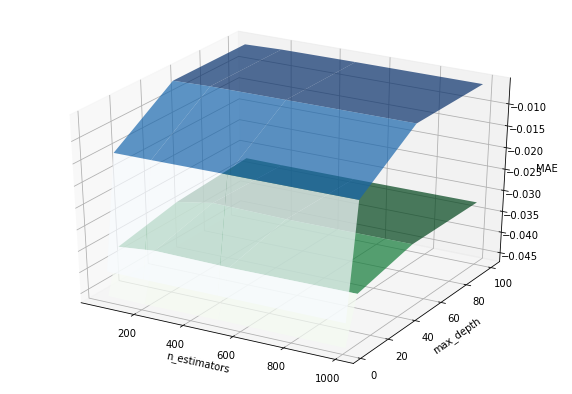

In [152]:
x, y  = gs_rf.param_grid.items()

Z_train = np.array(gs_rf.cv_results_["mean_train_score"]).reshape(len(x[1]), len(y[1]))
Z_test = np.array(gs_rf.cv_results_["mean_test_score"]).reshape(len(x[1]), len(y[1]))
X, Y = np.meshgrid(x[1],y[1])

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z_train, cmap="Blues", alpha=0.7, label="Training MAE")
ax.plot_surface(X, Y, Z_test, cmap="Greens", alpha=0.7, label="Validation MAE")

ax.set_xlabel(x[0])
ax.set_ylabel(y[0])
ax.set_zlabel("MAE")

fig.savefig("d:/COVID_predict/plots/hpt_RF.png", dpi=400)

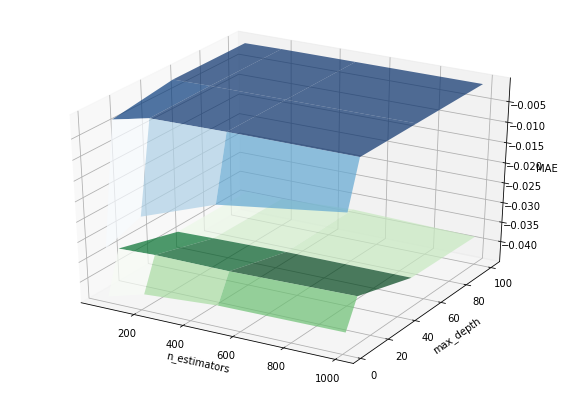

In [153]:
x, y  = gs_gb.param_grid.items()

Z_train = np.array(gs_gb.cv_results_["mean_train_score"]).reshape(len(x[1]), len(y[1]))
Z_test = np.array(gs_gb.cv_results_["mean_test_score"]).reshape(len(x[1]), len(y[1]))
X, Y = np.meshgrid(x[1],y[1])

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z_train, cmap="Blues", alpha=0.7, label="Training MAE")
ax.plot_surface(X, Y, Z_test, cmap="Greens", alpha=0.7, label="Validation MAE")

ax.set_xlabel(x[0])
ax.set_ylabel(y[0])
ax.set_zlabel("MAE")

fig.savefig("d:/COVID_predict/plots/hpt_GB.png", dpi=400)

In [154]:
# re-scale input for each column due to the different magnitudes of dataset,
# and this difference is too big for NN to quickly converge
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_nn = scaler.fit_transform(X_train)
X_test_nn = scaler.transform(X_test)

In [155]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense

In [156]:
nn_params = {"n_hidden_layers": [1, 2, 5], "n_units_per_layer":[50, 100, 200]}
x = nn_params["n_hidden_layers"]
y = nn_params["n_units_per_layer"]
X, Y = np.meshgrid(x,y)
Z_train = np.zeros((len(x), len(y)))
Z_test = np.zeros((len(x), len(y)))

def build_model(n_layer, n_neuron):
    model = Sequential()
    model.add(Dense(n_neuron, activation="relu", input_shape=(28,), kernel_initializer='random_normal', bias_initializer='zeros'))
    for _ in range(n_layer):
        model.add(Dense(n_neuron, activation="relu", kernel_initializer='random_normal', bias_initializer='zeros'))
    model.add(Dense(1, activation="sigmoid" , kernel_initializer='random_normal', bias_initializer='zeros'))
    return model

def GridSearch_NN(nn_params):
    dict_model = {}
    for i, n_layer in enumerate(x):
        for j, n_neuron in enumerate(y):
            model = build_model(n_layer, n_neuron)
            model.compile(loss="mae", optimizer="rmsprop")
            model.fit(X_train_nn, y_train, validation_data = (X_test_nn, y_test), batch_size=256, epochs=250, verbose=0)
            dict_model[(n_layer, n_neuron)] = model
            Z_train[i, j] = mean_absolute_error(model.predict(X_train_nn), y_train)
            Z_test[i, j] = mean_absolute_error(model.predict(X_test_nn), y_test)
            print("Done with " + str(n_layer) + " " + str(n_neuron))
            print(mean_absolute_error(model.predict(X_train_nn), y_train))
            print(mean_absolute_error(model.predict(X_test_nn), y_test))

In [157]:
GridSearch_NN(nn_params)









Done with 1 50
0.019406411485992214
0.04855785975264226
Done with 1 100
0.015126137439776187
0.048779542154978914
Done with 1 200
0.013157241228078077
0.047592134109560334
Done with 2 50
0.016184393765496755
0.049504586862992465
Done with 2 100
0.016810058331547233
0.04853644548633763
Done with 2 200
0.01050734156010583
0.046012390136549446
Done with 5 50
0.059594510263053
0.07814484634914494
Done with 5 100
0.009894337888105474
0.04946267510169992
Done with 5 200
0.006634196028302931
0.05101799557251172


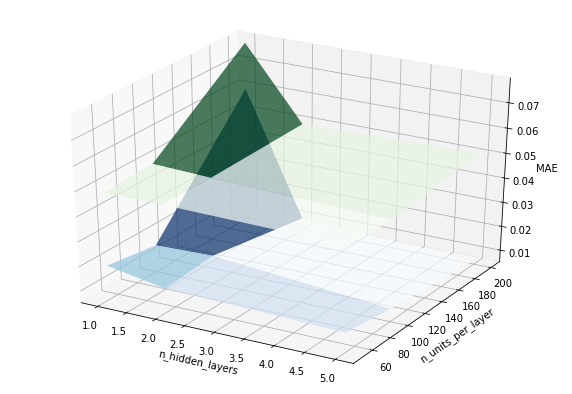

In [158]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z_train, cmap="Blues", alpha=0.7, label="Training MAE")
ax.plot_surface(X, Y, Z_test, cmap="Greens", alpha=0.7, label="Validation MAE")

ax.set_xlabel("n_hidden_layers")
ax.set_ylabel("n_units_per_layer")
ax.set_zlabel("MAE")

fig.savefig("d:/COVID_predict/plots/hpt_NN.png", dpi=400)

In [168]:
model = Sequential()
model.add(Dense(50, activation="relu", input_shape=(28,)))
model.add(Dense(50, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

model.compile(loss="mae", optimizer="rmsprop")
hist = model.fit(X_train_nn, y_train, batch_size=256, epochs=250, validation_data=(X_test_nn, y_test))

Train on 5100 samples, validate on 4998 samples
Epoch 1/250
5100/5100 [==============================] - 1s 103us/step - loss: 0.1610 - val_loss: 0.0648
Epoch 2/250
5100/5100 [==============================] - 0s 13us/step - loss: 0.0586 - val_loss: 0.0612
Epoch 3/250
5100/5100 [==============================] - 0s 12us/step - loss: 0.0497 - val_loss: 0.0599
Epoch 4/250
5100/5100 [==============================] - 0s 11us/step - loss: 0.0453 - val_loss: 0.0573
Epoch 5/250
5100/5100 [==============================] - 0s 11us/step - loss: 0.0405 - val_loss: 0.0562
Epoch 6/250
5100/5100 [==============================] - 0s 12us/step - loss: 0.0366 - val_loss: 0.0547
Epoch 7/250
5100/5100 [==============================] - 0s 13us/step - loss: 0.0339 - val_loss: 0.0546
Epoch 8/250
5100/5100 [==============================] - 0s 11us/step - loss: 0.0310 - val_loss: 0.0544
Epoch 9/250
5100/5100 [==============================] - 0s 12us/step - loss: 0.0294 - val_loss: 0.0529
Epoch 10/250
51

5100/5100 [==============================] - 0s 11us/step - loss: 0.0190 - val_loss: 0.0474
Epoch 79/250
5100/5100 [==============================] - 0s 11us/step - loss: 0.0185 - val_loss: 0.0477
Epoch 80/250
5100/5100 [==============================] - 0s 10us/step - loss: 0.0187 - val_loss: 0.0469
Epoch 81/250
5100/5100 [==============================] - 0s 11us/step - loss: 0.0189 - val_loss: 0.0477
Epoch 82/250
5100/5100 [==============================] - 0s 12us/step - loss: 0.0185 - val_loss: 0.0479
Epoch 83/250
5100/5100 [==============================] - 0s 12us/step - loss: 0.0183 - val_loss: 0.0475
Epoch 84/250
5100/5100 [==============================] - 0s 13us/step - loss: 0.0183 - val_loss: 0.0481
Epoch 85/250
5100/5100 [==============================] - 0s 13us/step - loss: 0.0185 - val_loss: 0.0478
Epoch 86/250
5100/5100 [==============================] - 0s 12us/step - loss: 0.0184 - val_loss: 0.0480
Epoch 87/250
5100/5100 [==============================] - 0s 12us/st

5100/5100 [==============================] - 0s 10us/step - loss: 0.0166 - val_loss: 0.0476
Epoch 156/250
5100/5100 [==============================] - 0s 11us/step - loss: 0.0166 - val_loss: 0.0475
Epoch 157/250
5100/5100 [==============================] - 0s 10us/step - loss: 0.0167 - val_loss: 0.0468
Epoch 158/250
5100/5100 [==============================] - 0s 11us/step - loss: 0.0166 - val_loss: 0.0480
Epoch 159/250
5100/5100 [==============================] - 0s 11us/step - loss: 0.0167 - val_loss: 0.0469
Epoch 160/250
5100/5100 [==============================] - 0s 12us/step - loss: 0.0170 - val_loss: 0.0473
Epoch 161/250
5100/5100 [==============================] - 0s 11us/step - loss: 0.0165 - val_loss: 0.0475
Epoch 162/250
5100/5100 [==============================] - 0s 13us/step - loss: 0.0171 - val_loss: 0.0479
Epoch 163/250
5100/5100 [==============================] - 0s 13us/step - loss: 0.0165 - val_loss: 0.0475
Epoch 164/250
5100/5100 [==============================] - 0

5100/5100 [==============================] - 0s 10us/step - loss: 0.0159 - val_loss: 0.0468
Epoch 233/250
5100/5100 [==============================] - 0s 10us/step - loss: 0.0156 - val_loss: 0.0472
Epoch 234/250
5100/5100 [==============================] - 0s 11us/step - loss: 0.0156 - val_loss: 0.0465
Epoch 235/250
5100/5100 [==============================] - 0s 11us/step - loss: 0.0159 - val_loss: 0.0463
Epoch 236/250
5100/5100 [==============================] - 0s 10us/step - loss: 0.0157 - val_loss: 0.0469
Epoch 237/250
5100/5100 [==============================] - 0s 10us/step - loss: 0.0158 - val_loss: 0.0479
Epoch 238/250
5100/5100 [==============================] - 0s 12us/step - loss: 0.0158 - val_loss: 0.0481
Epoch 239/250
5100/5100 [==============================] - 0s 12us/step - loss: 0.0156 - val_loss: 0.0473
Epoch 240/250
5100/5100 [==============================] - 0s 12us/step - loss: 0.0157 - val_loss: 0.0467
Epoch 241/250
5100/5100 [==============================] - 0

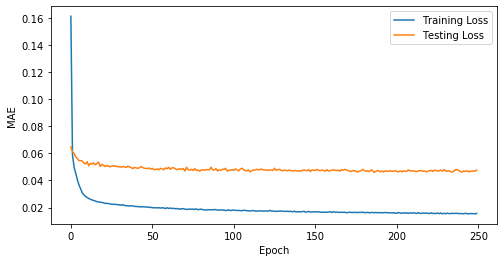

In [169]:
fig, ax = plt.subplots(1,1, figsize=(8,4))
ax.plot(hist.history["loss"], label="Training Loss")
ax.plot(hist.history["val_loss"], label="Testing Loss")
ax.legend()
ax.set_xlabel("Epoch")
ax.set_ylabel("MAE")
fig.savefig("d:/COVID_predict/plots/NN_loss.png", dpi=400)

### 2.3 Compare Models

In [170]:
results = []

In [171]:
lr = LinearRegression()
lr.fit(X_train, y_train)
mae_train = mean_absolute_error(lr.predict(X_train), y_train)
mae_test = mean_absolute_error(lr.predict(X_test), y_test)
results.append(["Linear Regression", None, mae_train, mae_test])

In [172]:
rf = RandomForestRegressor(n_estimators=100, max_depth=100)
rf.fit(X_train, y_train)
mae_train = mean_absolute_error(rf.predict(X_train), y_train)
mae_test = mean_absolute_error(rf.predict(X_test), y_test)
results.append(["Random Forest", {"n_estimator":100, "max_depth":100}, mae_train, mae_test])

In [173]:
gb = GradientBoostingRegressor(n_estimators=1000, max_depth=10)
gb.fit(X_train, y_train)
mae_train = mean_absolute_error(gb.predict(X_train), y_train)
mae_test = mean_absolute_error(gb.predict(X_test), y_test)
results.append(["Gradient Boosting", {"n_estimator":1000, "max_depth":10}, mae_train, mae_test])

In [174]:
mae_train = mean_absolute_error(model.predict(X_train_nn), y_train)
mae_test = mean_absolute_error(model.predict(X_test_nn), y_test)
results.append(["Neural Network", {"n_hidden_layer":2, "n_neuron":[50,50]}, mae_train, mae_test])

In [175]:
results = pd.DataFrame(results, columns=["Name", "HyperParameters", "Training MAE", "Testing MAE"]).set_index("Name")
results

,HyperParameters,Training MAE,Testing MAE
Name,,,
Linear Regression,None,0.040022,0.086512
Random Forest,"{'n_estimator': 100, 'max_depth': 100}",0.005316,0.053584
Gradient Boosting,"{'n_estimator': 1000, 'max_depth': 10}",0.000251,0.053601
Neural Network,"{'n_hidden_layer': 2, 'n_neuron': [50, 50]}",0.015156,0.047635


### 2.4 Feature importance for random forest and gradient boosting

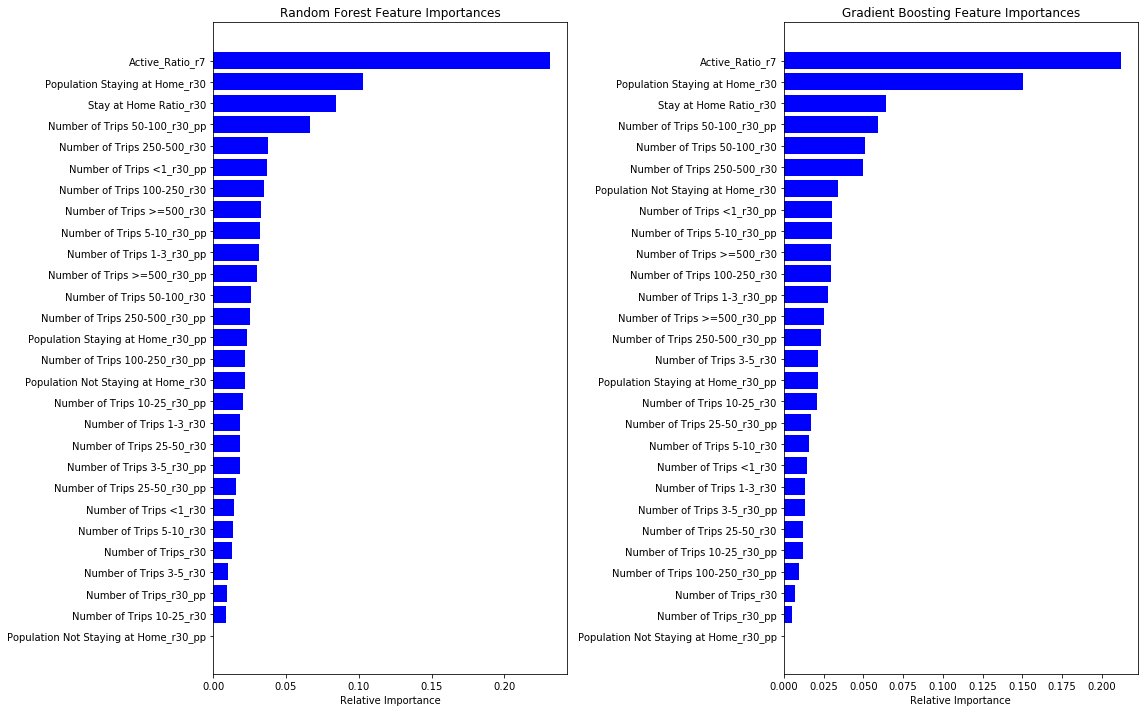

In [176]:
features = feature_cols

rf_importances = rf.feature_importances_
rf_indices = np.argsort(rf_importances)

gb_importances = gb.feature_importances_
gb_indices = np.argsort(gb_importances)

fig, axs = plt.subplots(1, 2, figsize=(16, 10), tight_layout=True)
axs[0].set_title('Random Forest Feature Importances')
axs[0].barh(range(len(rf_indices)), rf_importances[rf_indices], color='b', align='center')
axs[0].set_yticks(range(len(rf_indices)))
axs[0].set_yticklabels([features[i] for i in rf_indices])
axs[0].set_xlabel('Relative Importance')

axs[1].set_title('Gradient Boosting Feature Importances')
axs[1].barh(range(len(gb_indices)), gb_importances[gb_indices], color='b', align='center')
axs[1].set_yticks(range(len(gb_indices)))
axs[1].set_yticklabels([features[i] for i in gb_indices])
axs[1].set_xlabel('Relative Importance')

fig.savefig("d:/COVID_predict/plots/feature_importance.png", dpi=400)

## 3. Assemble ML with simulation

In [177]:
data_pred = data_ml.copy()

In [178]:
df_slice = df_all[["Province_State", "Last_Update", "Active", "Total_pop", "Deaths_Daily", "Recovered_Daily"]]
df_slice.loc[:,"Last_Update"] = pd.to_datetime(df_slice["Last_Update"])
df_slice.columns = ["Province_State", "Date", "Active_pred", "Total_pop", "Deaths_Daily_pred", "Recovered_Daily_pred"]
data_pred = data_pred.merge(df_slice, how="left", on=["Province_State", "Date"])

C:\Users\zequn\.conda\envs\ml\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [179]:
data_pred["Tested_Daily_pred"] = data_pred.apply(lambda row: int(dict_state_params[row["Province_State"]]["People_Tested_PolyCoef"]*(1+2*(row["Date"]-datetime.datetime(2020, 4, 12)).days)), axis=1)

In [180]:
for idx, row in data_pred.iloc[n_train_days*51:,:].iterrows():
    
    idx_7 = [idx-51*i for i in range(1,8,1)]
    It_r7 = np.mean(data_pred.loc[idx_7, "Active_pred"] / data_pred.loc[idx_7, "Total_pop"])
    x_ = scaler.transform(np.array([[It_r7] + row[feature_cols[1:]].values.tolist()]))
    dI = int(row["Tested_Daily_pred"] * model.predict(x_)[0])
    dD = int(dI * dict_state_params[row["Province_State"]]["death_rate"])
    dR = int(dI * dict_state_params[row["Province_State"]]["recover_rate"])
    dI_ = dI - dD - dR
    data_pred.loc[idx, "Active_pred"] = dI_ + data_pred.loc[idx-51, "Active_pred"]
    data_pred.loc[idx, "Deaths_Daily_pred"] = dD
    data_pred.loc[idx, "Recovered_Daily_pred"] = dR

In [181]:
df_slice = df_slice[["Province_State", "Date", "Active_pred"]]
df_slice.columns = ["Province_State", "Date", "Active_true"]
data_pred = data_pred.merge(df_slice[["Province_State", "Date", "Active_true"]], how="left", on=["Province_State", "Date"])

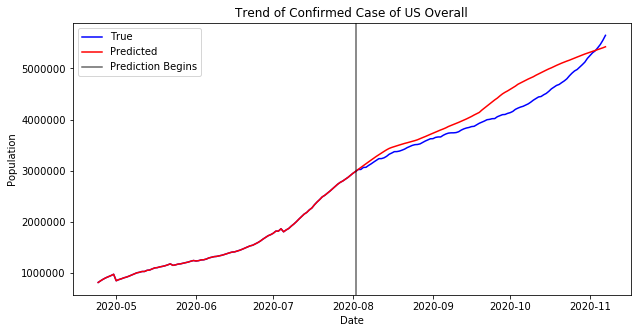

In [183]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
data_us = data_pred.groupby("Date")[["Active_pred", "Active_true"]].sum()
ax.plot(data_us["Active_true"], c="Blue", label="True")
ax.plot(data_us["Active_pred"], c="Red", label="Predicted")
ax.axvline(x=data_us.index.values[n_train_days], ymin=0 , ymax=data_us["Active_pred"].max(), c="k", alpha=0.6, label="Prediction Begins")
ax.set_xlabel("Date")
ax.set_ylabel("Population")
ax.set_title("Trend of Confirmed Case of US Overall")
ax.legend()

fig.savefig("d:/COVID_predict/plots/confirmed_trend_US.png", dpi=400)

In [184]:
for i, (name, df) in enumerate(data_pred.groupby("Province_State")):
    fig, axs = plt.subplots(1, 1, figsize=(10, 5), tight_layout=True)
    axs.plot(df["Date"], df["Active_true"], c="blue", label="True")
    axs.plot(df["Date"], df["Active_pred"], c="red", label="Predicted")
    axs.axvline(x=df["Date"].values[n_train_days], ymin=0 , ymax=df["Active_pred"].max(), c="k", alpha=0.6, label="Prediction Begins")
    axs.set_title("Trend of Confirmed Case of " + name)
    axs.set_xlabel("Date")
    axs.set_ylabel("Population")
    axs.legend(loc="upper left")
    fig.savefig("d:/COVID_predict/plots/confirmed_trend_"+name+".png", dpi=400)
    plt.close(fig)

### Hospital data: updated daily, but archive data not available

In [54]:
hospital = pd.read_csv("data/State_Representative_Estimates_for_Hospital_Utilization.csv")
hospital.head(5)

,OBJECTID,state_name,total_inpatient_beds,total_icu_beds,pct_inpatient_bed_utilization,pct_inpatients_with_covid,pct_icu_bed_utilization,icu_beds_used_estimate,inpatient_beds_used_estimate,inpatient_beds_used_covid_est,last_updated
0,1,Alaska,1178.0,228.0,62.51,7.29,75.40,95.0,892.0,104.0,2020/11/06 14:45:00+00
1,2,California,60674.0,8744.0,71.60,5.60,70.22,5073.0,44587.0,3490.0,2020/11/06 14:45:00+00
2,3,Hawaii,1745.0,299.0,68.56,3.29,69.96,170.0,1700.0,81.0,2020/11/06 14:45:00+00
3,4,Idaho,3604.0,513.0,54.96,8.82,75.59,223.0,1932.0,310.0,2020/11/06 14:45:00+00
4,5,Nevada,7311.0,1152.0,75.31,10.37,75.09,642.0,5500.0,738.0,2020/11/06 14:45:00+00


### Temperature data: station-wise daily average temperature for 2017. [Downloaded]

### Marginal death rate: https://www.ssa.gov/oact/STATS/table4c6.html or https://www.cdc.gov/nchs/data/dvs/MortFinal2007_Worktable23f.pdf
### Bayes rule: P(Death|Covid) * P(Covid) = P(Death, Covid) = P(Covid|Death) * P(Death)
### Add demographic data somewhere
#### => P(Covid|Death) = P(Death|Covid) * P(Covid) / P(Death)
##### - P(Death|Covid): Estimated as in the death rate table above
##### - P(Covid): Estimated as in test positive probability as above
##### - P(Death): Lookup from the link in this block